<a href="https://colab.research.google.com/github/sourcecode369/unconventional-neural-networks/blob/master/deep-dreams/deep_dream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, print_function, unicode_literals, division

In [0]:
%tensorflow_version 2.x
import tensorflow as tf 
print("TensorFlow version: {}".format(tf.__version__))

TensorFlow 2.x selected.
TensorFlow version: 2.0.0


In [0]:
import os
import PIL.Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from IPython.display import clear_output
from tensorflow.keras.preprocessing import image

In [0]:
URL = 'https://scontent.fdel8-1.fna.fbcdn.net/v/t31.0-8/p720x720/13217602_998740486877216_2902139444688028875_o.jpg?_nc_cat=105&_nc_ohc=gXeBOqY29lIAQnS1P3pvmSZ3V0viyQ7BAF7VBoesNntHboRqS_aKRuMsg&_nc_ht=scontent.fdel8-1.fna&oh=7a36163fbaea33c0976461ed4f490cc2&oe=5E7D567A'
style_path2 = tf.keras.utils.get_file('style.jpg',"https://wallpaperaccess.com/full/31367.jpg")
content_path = tf.keras.utils.get_file('content.jpg','https://scontent.fdel8-1.fna.fbcdn.net/v/t31.0-8/p720x720/13217602_998740486877216_2902139444688028875_o.jpg?_nc_cat=105&_nc_ohc=gXeBOqY29lIAQnS1P3pvmSZ3V0viyQ7BAF7VBoesNntHboRqS_aKRuMsg&_nc_ht=scontent.fdel8-1.fna&oh=7a36163fbaea33c0976461ed4f490cc2&oe=5E7D567A')

131072/125852 [===============================] - 1s 9us/step


131072/125852 [===============================] - 1s 9us/step


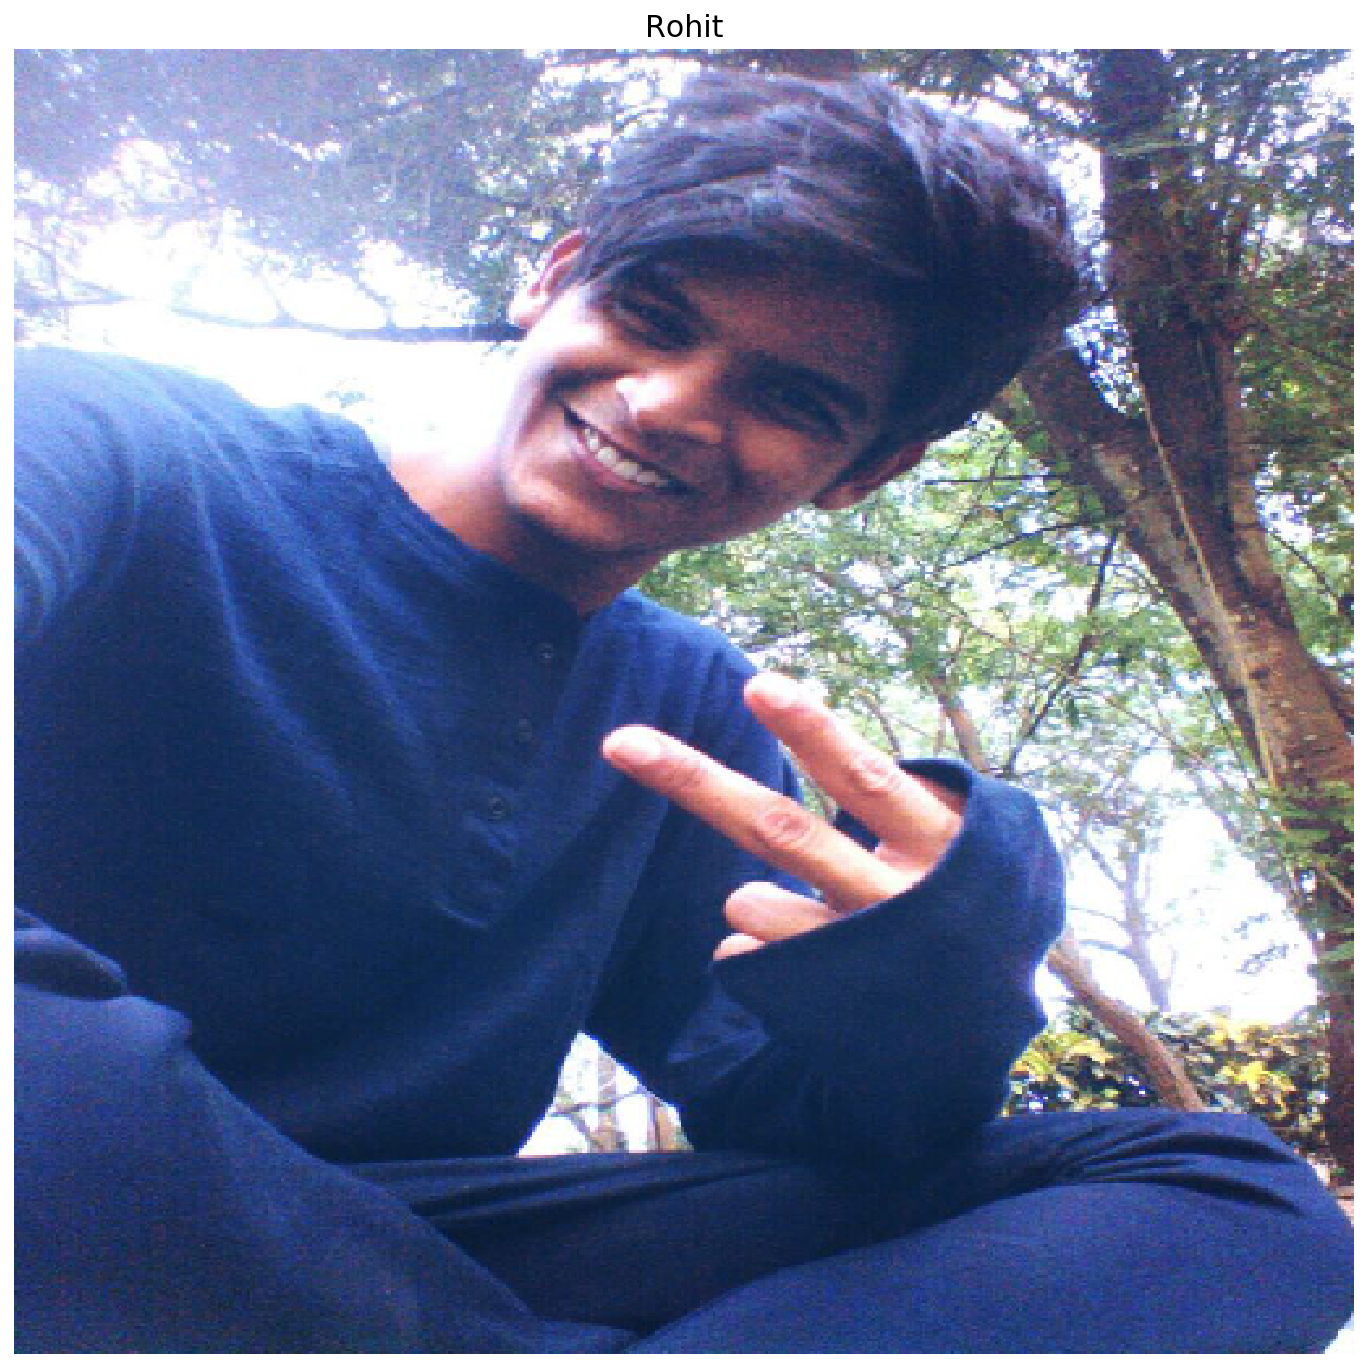

In [0]:
# Download an image
def download(url, target_size=None):
  # name = url.split('/')[-1]
  name = 'galaxy.jpg'
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
  return img

# Normalize an image
def deprocess(img):
  img = 255 * (img + 1.0) / 2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img, title=None):
  if len(img.shape)>3:
    img = np.squeeze(img)
  plt.figure(figsize=(12,12))
  plt.grid(False)
  plt.axis('off')
  plt.imshow(img, interpolation='nearest', aspect="auto")
  if title:
    plt.title(title, fontsize=15)
  plt.show()

original_image = download(URL, target_size=[512,512])
original_image = np.array(original_image)
show(original_image, title="Rohit") 

In [0]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [0]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

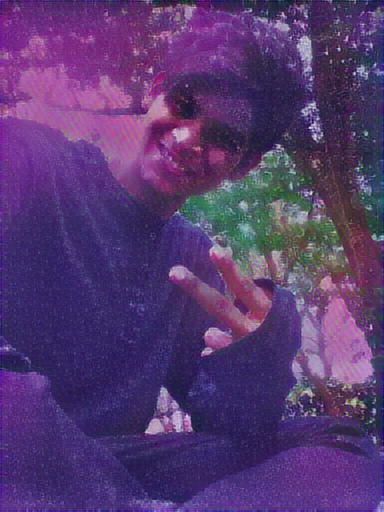

In [0]:
content_image = load_img(content_path)
style_image = img = load_img(style_path2)
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [0]:
base_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False, weights="imagenet")

87916544/87910968 [==============================] - 4s 0us/step


The idea in DeepDream is to choose a layer (or layers) and maximize the "loss" in a way that the image increasingly "excites" the layers. The complexity of the features incorporated depends on layers chosen by you, i.e, lower layers produce strokes or simple patterns, while deeper layers give sophisticated features in images, or even whole objects.



The InceptionV3 architecture is quite large (for a graph of the model architecture see TensorFlow's research repo). For DeepDream, the layers of interest are those where the convolutions are concatenated. There are 11 of these layers in InceptionV3, named 'mixed0' though 'mixed10'. Using different layers will result in different dream-like images. Deeper layers respond to higher-level features (such as eyes and faces), while earlier layers respond to simpler features (such as edges, shapes, and textures). Feel free to experiment with the layers selected below, but keep in mind that deeper layers (those with a higher index) will take longer to train on since the gradient computation is deeper.


In [0]:
for layer in base_model.layers:
  if "mixed" in layer.name:
    print(layer.name)

mixed0
mixed1
mixed2
mixed3
mixed4
mixed5
mixed6
mixed7
mixed8
mixed9_0
mixed9
mixed9_1
mixed10


In [0]:
# prepare feature extraction model
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

deep_dream = tf.keras.models.Model(base_model.input, layers)

In [0]:
# calculate loss
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_sum(act)
    losses.append(loss)
  return tf.reduce_sum(losses)

In [0]:
# gradient ascent
@tf.function
def deepdream(model, img, step_size):
  with tf.GradientTape(watch_accessed_variables=True) as tape:
    # This needs gradients relative to `img`
    # `GradientTape` only watches `tf.Variable`s by default
    tape.watch(img)
    loss = calc_loss(img, model)
  # Calculate the gradient of the loss with respect to the pixels of the input image.
  gradients = tape.gradient(loss, img)

  # Normalize the gradients.
  gradients /= tf.math.reduce_std(gradients) + 1e-8 

  # gradient ascent
  img = img + gradients * step_size

  img = tf.clip_by_value(img, clip_value_max=1.0, clip_value_min=-1.0)

  return loss, img

In [0]:
def run_deep_dream_simple(model, img, steps=100, step_size=0.01):
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  for step in range(steps):
    loss, img = deepdream(model, img, step_size)
    if step % 100 == 0:
      clear_output(wait=True)
      show(deprocess(img))
      print(f"Step {step}, Loss {loss}")

  result = deprocess(img)
  clear_output(wait = True)
  show(result)

  return result

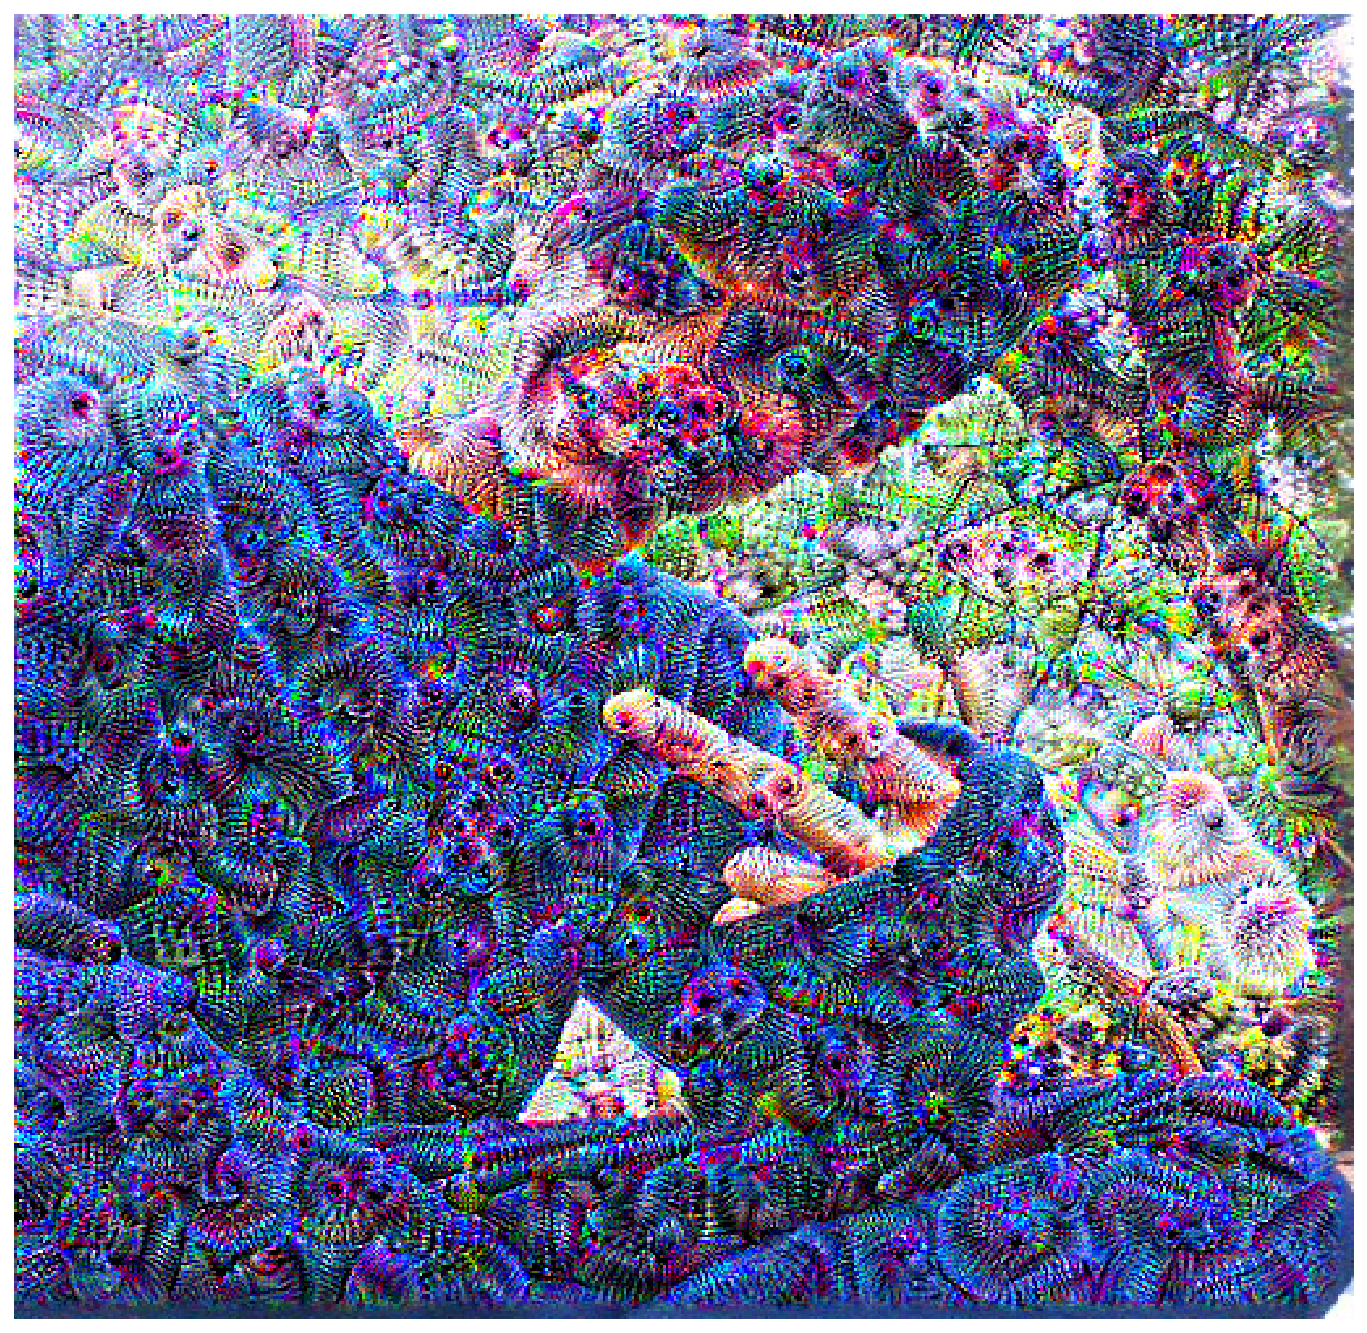

In [0]:
dream_img = run_deep_dream_simple(model=deep_dream, img=original_image, steps=600, step_size=0.01)

### Taking it up an octave

1. The output is noisy. This can be addressed by tf.image.total_variation.

2. The image is low resolution.

3. The patterns appear like they are all happening at the same granularity.

One approach that addresses all these problems is applying gradient ascent at different scales. This will allow patterns generated at smaller scales to be incorporated into patterns at higher scales and filled in with additional detail.

To do this you can perform the previous gradient ascent approach, then increase the size of the image (which is reffered to as an octave), and repeat this process for multiple octaves.

In [0]:
OCTAVE_SCALE = 1.3
img = tf.constant(np.array(original_image))
base_shape = tf.cast(tf.shape(img)[:-1], tf.float32)

for n in range(3):
  new_shape = tf.cast(base_shape*(OCTAVE_SCALE**n), tf.int32)
  img = tf.image.resize(img, new_shape).numpy()
  img = run_deep_dream_simple(model=deep_dream, img = img, steps=300, step_size=0.01)

### Scaling up with tiles

One thing to consider is that as the image increases in size, so will the time and memory necessary to perform the gradient calculation. The above octave implementation will not work on very large images, or many octaves.

To avoid this issue you can split the image into tiles and compute the gradient for each tile.

Applying random shifts to the image before each tiled computation prevents tile seams from appearing.

In [0]:
def random_roll(img, maxroll):
  shift = tf.random.uniform(shape=[2], minval = -maxroll, maxval=maxroll, dtype=tf.int32)
  shift_down, shift_right = shift[0], shift[1]
  img_rolled = tf.roll(tf.roll(img, shift_right, axis=1), shift_down, axis=0)
  return shift_down, shift_right, img_rolled

In [0]:
shift_down, shift_right, img_rolled = random_roll(np.array(original_image), 512)
show(img_rolled)

In [0]:
@tf.function
def get_tiled_gradients(model, img, tile_size=512):
  shift_down, shift_right, img_rolled = random_roll(img, tile_size)
  gradients = tf.zeros_like(img_rolled)
  for x in tf.range(0, img_rolled.shape[0], tile_size):
    for y in tf.range(0, img_rolled.shape[1], tile_size):
      with tf.GradientTape(watch_accessed_variables=True) as tape:
        tape.watch(img_rolled)
        img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
        loss = calc_loss(img_tile, model)

      gradients = gradients + tape.gradient(loss, img_rolled)

  gradients = tf.roll(tf.roll(gradients, -shift_right, axis=1), -shift_down, axis=0)
  gradients /= tf.math.reduce_std(gradients) + 1e-8
  return gradients 

In [0]:
def run_deep_dream_with_octaves(model, img, steps_per_octave=100, step_size=0.01, 
                                num_octaves=3, octave_scale=1.3):
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  for octave in range(num_octaves):
    # Scale the image based on the octave
    if octave>0:
      new_size = tf.cast(tf.convert_to_tensor(img.shape[:2]), tf.float32)*octave_scale
      img = tf.image.resize(img, tf.cast(new_size, tf.int32))

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(model, img)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        clear_output(wait=True)
        show(deprocess(img))
        print ("Octave {}, Step {}".format(octave, step))
    
  clear_output(wait=True)
  result = deprocess(img)
  show(result)

  return result

In [0]:
dream_img = run_deep_dream_with_octaves(model=deep_dream, img=original_image, step_size=0.01, num_octaves=4, steps_per_octave=160)
clear_output()
show(original_image)
show(dream_img)